In [ ]:
!pip3 install keras-tuner --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import keras_tuner
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout
import tensorflow as tf
import sklearn.metrics as metrics
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [ ]:
price_usd_df=pd.read_excel("/content/drive/MyDrive/Dissertation/My Dissertation/Data/Pre-processed results/Removed missing values.xlsx")

print(price_usd_df.dtypes)
price_usd_df.head(21)
df=price_usd_df

Date      datetime64[ns]
XBTUSD           float64
AUDUSD           float64
CADUSD           float64
CNYUSD           float64
EURUSD           float64
GBPUSD           float64
JPYUSD           float64
NZDUSD           float64
SGDUSD           float64
dtype: object


In [ ]:
def mean_absolute_percentage_error(y_test,y_pred):
    y_test = np.array(y_test)
    y_pred = np.array(y_pred)
    errors = abs(y_test - y_pred)
    mape = 100 * np.mean(errors / y_test)
    print('mape---{}'.format(mape))
    mape1= np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    
    return mape

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def calculate_metrics(y, ypred):
    MAE = metrics.mean_absolute_error(y, ypred)
    RMSE = metrics.mean_squared_error(y, ypred,squared=False)
    mse=metrics.mean_squared_error(y,ypred)
    r2=metrics.r2_score(y,ypred)

    return MAE,RMSE,mse,r2

In [ ]:
dates=df['Date'].values

In [ ]:
cols = list(df)[1:]
cols

['XBTUSD',
 'AUDUSD',
 'CADUSD',
 'CNYUSD',
 'EURUSD',
 'GBPUSD',
 'JPYUSD',
 'NZDUSD',
 'SGDUSD']

In [ ]:
df1=df[cols]

In [ ]:
df1

,XBTUSD,AUDUSD,CADUSD,CNYUSD,EURUSD,GBPUSD,JPYUSD,NZDUSD,SGDUSD
0,1024.38,0.7219,0.7448,0.14385,1.0405,1.2237,0.008493,0.6918,0.6895
1,1091.66,0.7283,0.7519,0.14504,1.0489,1.2323,0.008529,0.6970,0.6948
2,971.26,0.7338,0.7562,0.14547,1.0607,1.2419,0.008669,0.7026,0.7001
3,898.16,0.7301,0.7555,0.14424,1.0532,1.2287,0.008547,0.6960,0.6950
4,917.41,0.7301,0.7555,0.14424,1.0532,1.2287,0.008547,0.6960,0.6950
...,...,...,...,...,...,...,...,...,...
1831,20930.58,0.6793,0.7678,0.14799,1.0080,1.1855,0.007220,0.6165,0.7144
1832,21487.97,0.6812,0.7701,0.14830,1.0143,1.1953,0.007240,0.6154,0.7156
1833,23304.71,0.6897,0.7770,0.14827,1.0227,1.1995,0.007236,0.6225,0.7181
1834,23258.12,0.6888,0.7762,0.14805,1.0180,1.1973,0.007235,0.6239,0.7176


In [ ]:
df1_scaled=df1.values

In [ ]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [ ]:
lag = 7 #adding 3 hours lags creating number of observations 
n_features = 9 #Features in the dataset.
n_obs = lag*n_features


In [ ]:
reframed = series_to_supervised(df1_scaled, lag, 1)
reframed.head()

,var1(t-7),var2(t-7),var3(t-7),var4(t-7),var5(t-7),var6(t-7),var7(t-7),var8(t-7),var9(t-7),var1(t-6),...,var9(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t),var9(t)
7,1024.38,0.7219,0.7448,0.14385,1.0405,1.2237,0.008493,0.6918,0.6895,1091.66,...,0.6963,789.11,0.7441,0.7589,0.14471,1.0582,1.2213,0.008665,0.7055,0.7008
8,1091.66,0.7283,0.7519,0.14504,1.0489,1.2323,0.008529,0.6970,0.6948,971.26,...,0.7008,827.63,0.7484,0.7608,0.14515,1.0613,1.2162,0.008717,0.7095,0.7006
9,971.26,0.7338,0.7562,0.14547,1.0607,1.2419,0.008669,0.7026,0.7001,898.16,...,0.7006,830.70,0.7502,0.7625,0.14506,1.0643,1.2182,0.008733,0.7131,0.6998
10,898.16,0.7301,0.7555,0.14424,1.0532,1.2287,0.008547,0.6960,0.6950,917.41,...,0.6998,822.20,0.7502,0.7625,0.14506,1.0643,1.2182,0.008733,0.7131,0.6998
11,917.41,0.7301,0.7555,0.14424,1.0532,1.2287,0.008547,0.6960,0.6950,897.51,...,0.6998,833.10,0.7477,0.7589,0.14506,1.0601,1.2047,0.008757,0.7103,0.6991


In [ ]:
values = reframed.values
split_point = int(0.8*len(values))
train = values[:split_point, :]
test = values[split_point:, :]
train.shape,test.shape

((1463, 72), (366, 72))

In [ ]:
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]


In [ ]:
train_X = train_X.reshape((train_X.shape[0], lag, n_features))
test_X = test_X.reshape((test_X.shape[0], lag, n_features))
test_y=test_y.reshape(-1,1)
train_y=train_y.reshape(-1,1)
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1463, 7, 9) (1463, 1) (366, 7, 9) (366, 1)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
model = Sequential()
model.add(Bidirectional(LSTM(64, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True)))
model.add(Bidirectional(LSTM(32, activation='relu', return_sequences=True)))
model.add(Bidirectional(LSTM(16, activation='relu', return_sequences=False)))
model.add(Dropout(0.1))
model.add(Dense(train_y.shape[1]))

model.compile(optimizer=Adam(learning_rate=0.0001), loss='mae')
#model.summary()

In [ ]:
history = model.fit(train_X, train_y, epochs=35, batch_size=8,validation_split=0.2, verbose=1)

Epoch 1/35
147/147 [==============================] - 6s 14ms/step - loss: 7201.9136 - val_loss: 34948.0352
Epoch 2/35
147/147 [==============================] - 1s 10ms/step - loss: 6473.0508 - val_loss: 31553.6934
Epoch 3/35
147/147 [==============================] - 1s 10ms/step - loss: 5765.3237 - val_loss: 27575.6035
Epoch 4/35
147/147 [==============================] - 1s 10ms/step - loss: 4466.7856 - val_loss: 16249.2969
Epoch 5/35
147/147 [==============================] - 1s 10ms/step - loss: 4455.9487 - val_loss: 23017.4160
Epoch 6/35
147/147 [==============================] - 1s 10ms/step - loss: 3837.5679 - val_loss: 12415.1709
Epoch 7/35
147/147 [==============================] - 1s 10ms/step - loss: 3399.9558 - val_loss: 26895.7969
Epoch 8/35
147/147 [==============================] - 1s 10ms/step - loss: 3972.1748 - val_loss: 10878.6719
Epoch 9/35
147/147 [==============================] - 1s 10ms/step - loss: 2653.9666 - val_loss: 11435.1240
Epoch 10/35
147/147 [=======

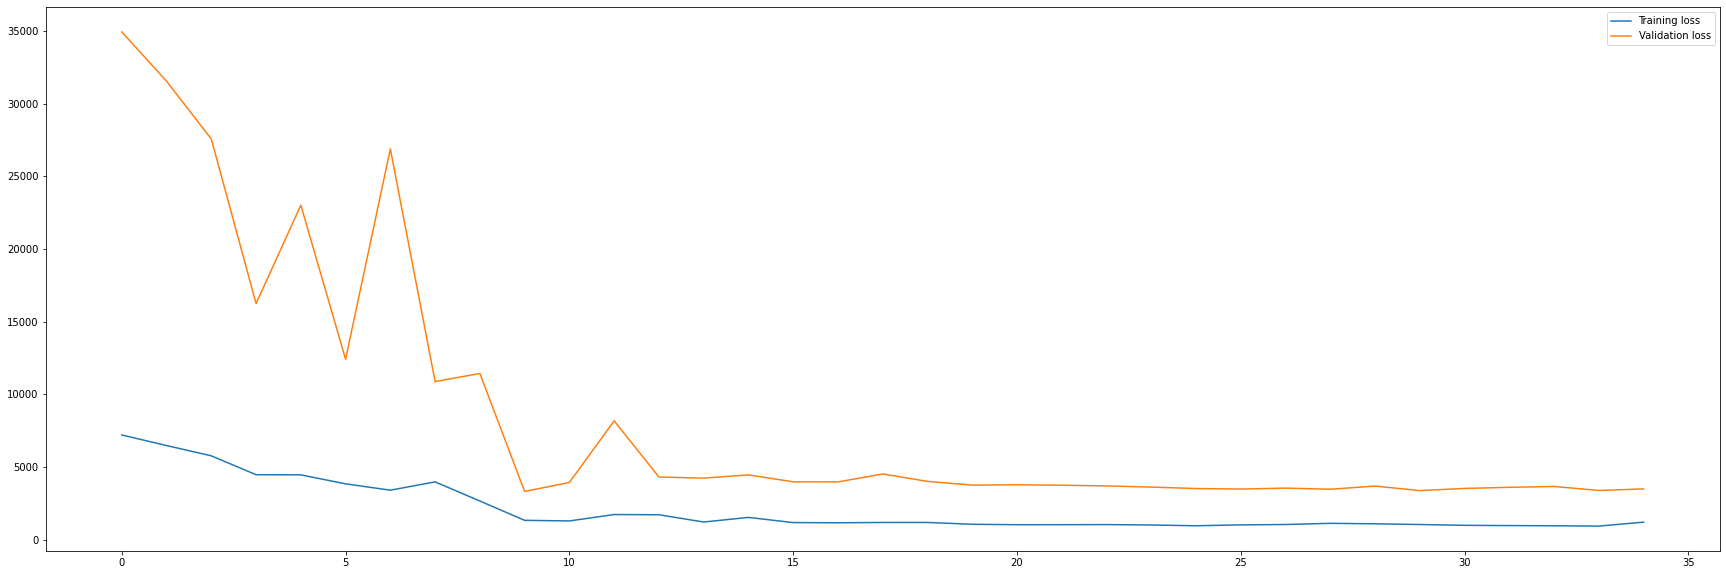

In [ ]:
plt.rcParams["figure.figsize"] = (30,10)
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [ ]:
prediction = model.predict(test_X)

In [ ]:
y_pred_future=prediction.reshape(-1,1)

In [ ]:
y_pred_future.shape

(366, 1)

In [ ]:
test_y.shape

(366, 1)

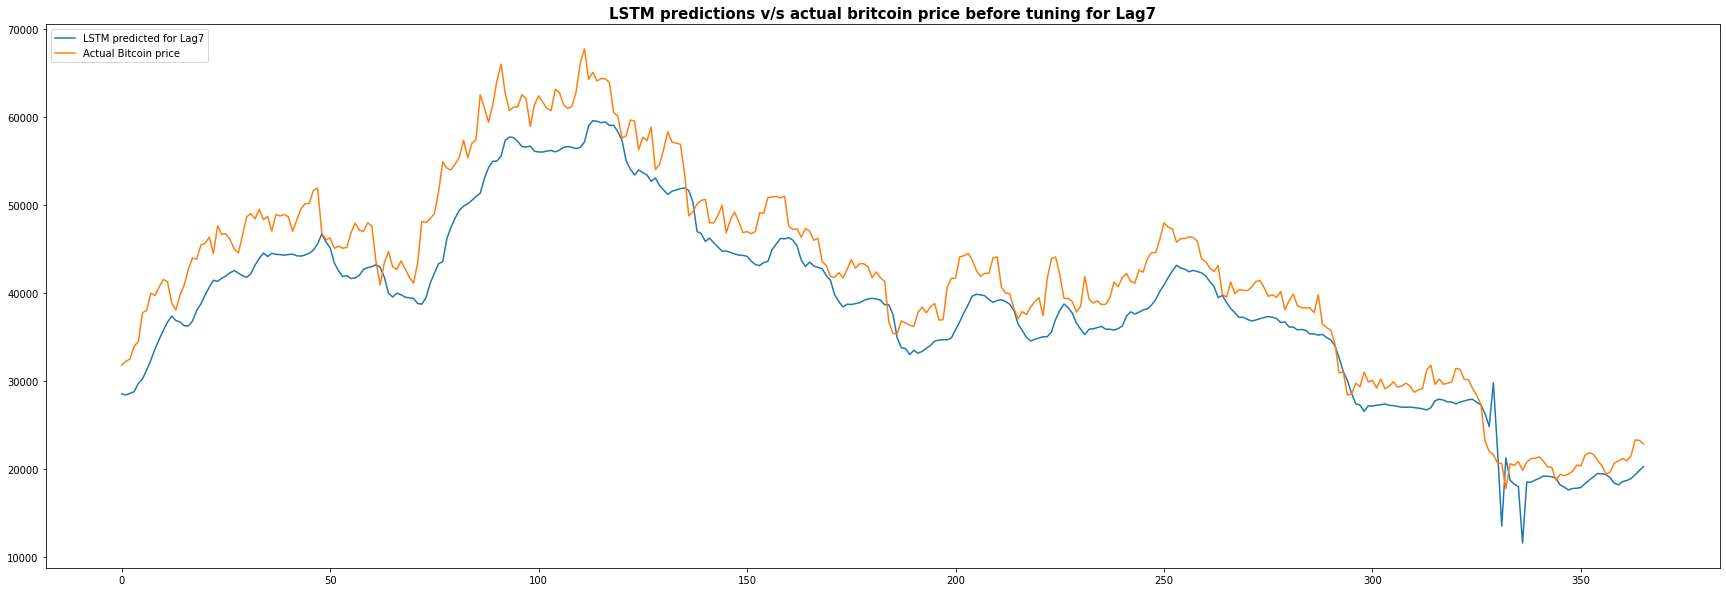

In [ ]:
plt.rcParams["figure.figsize"] = (30,10)
plt.plot(y_pred_future,label='LSTM predicted for Lag7')
plt.plot(test_y,label='Actual Bitcoin price')
plt.title('LSTM predictions v/s actual britcoin price before tuning for Lag7',fontweight="bold",fontsize = 15)
plt.legend(loc="upper left")
plt.show()

In [ ]:
mape = mean_absolute_percentage_error(test_y,y_pred_future)
mae,rmse,mse,r2=calculate_metrics(test_y,y_pred_future)
print('Results of LSTM model ')
print('MAPE  :{:0.4f}'.format(mape))
print('MAE  :{:0.4f}'.format(mae))
print('RMSE :{:0.4f} '.format(rmse))
print('MSE :{:0.4f} '.format(mse))
print('r2 :{:0.4f} '.format(r2))

mape---9.01440808494044
Results of LSTM model 
MAPE  :9.0144
MAE  :3774.2860
RMSE :4319.0396 
MSE :18654103.2048 
r2 :0.8558 


In [ ]:
print('mean of test Y   :{:0.4f}'.format(test_y.mean()))
print('max of test Y   :{:0.4f}'.format(test_y.max()))
print('min of test Y   :{:0.4f}'.format(test_y.min()))

scaled_rmse_tuned=rmse/(test_y.max()-test_y.min())
print('scaled_rmse   :{:0.4f}'.format(scaled_rmse_tuned))

mean of test Y   :42215.6181
max of test Y   :67734.0400
min of test Y   :17785.0900
scaled_rmse   :0.0865
